# pynucastro usage examples

This notebook illustrates some of the higher-level data structures in `pynucastro`.

Note to run properly, you install pynucastro via:

```
python setup.py install
```

(optionally with ``--user``)

In [1]:
import pynucastro as pyna

## Loading a single rate

The `Rate` class holds a single reaction rate and takes a reaclib file as input.  There are a lot of methods in the `Rate` class that allow you to explore the rate.

In [2]:
c13pg = pyna.Rate("c13-pg-n14-nacr")

### the original reaclib source

we can easily see the original source from ReacLib

In [3]:
print(c13pg.original_source)

4                                                                         
                                                                          
                                                                          
         p  c13  n14                       nacrn     7.55100e+00          
 1.851550e+01 0.000000e+00-1.372000e+01-4.500180e-01                      
 3.708230e+00-1.705450e+00-6.666670e-01                                   
         p  c13  n14                       nacrr     7.55100e+00          
 1.396370e+01-5.781470e+00 0.000000e+00-1.967030e-01                      
 1.421260e-01-2.389120e-02-1.500000e+00                                   
         p  c13  n14                       nacrr     7.55100e+00          
 1.518250e+01-1.355430e+01 0.000000e+00 0.000000e+00                      
 0.000000e+00 0.000000e+00-1.500000e+00                                   



This is a rate that consists of 3 sets, each of which has 7 coefficients in a form:

$$\lambda = \exp \left [ a_0 + \sum_{i=1}^5 a_i T_9^{(2i-5)/3} + a_6 \ln T_9 \right ]$$

### evaluate the rate at a given temperature (in K)

This is just the temperature dependent portion of the rate, usually expressed as $N_A \langle \sigma v \rangle$

In [4]:
c13pg.eval(1.e9)

3883.4778216250666

### human readable string

We can print out a string describing the rate, and the nuclei involved

In [5]:
print(c13pg)

c13 + p --> n14


The nuclei involved are all `Nucleus` objects.  They have members `Z` and `N` that give the proton and neutron number

In [6]:
print(c13pg.reactants)
print(c13pg.products)

[p, c13]
[n14]


In [7]:
r2 = c13pg.reactants[1]

Note that each of the nuclei are a pynucastro `Nucleus` type

In [8]:
type(r2)

pynucastro.rates.rate.Nucleus

In [9]:
print(r2.Z, r2.N)

6 7


### temperature sensitivity

We can find the temperature sensitivity about some reference temperature.  This is the exponent when we write the rate as 

$$r = r_0 \left ( \frac{T}{T_0} \right )^\nu$$.

We can estimate this given a reference temperature, $T_0$

In [10]:
c13pg.get_rate_exponent(2.e7)

16.21089670710968

### plot the rate's temperature dependence

A reaction rate has a complex temperature dependence that is defined in the reaclib files.  The `plot()` method will plot this for us

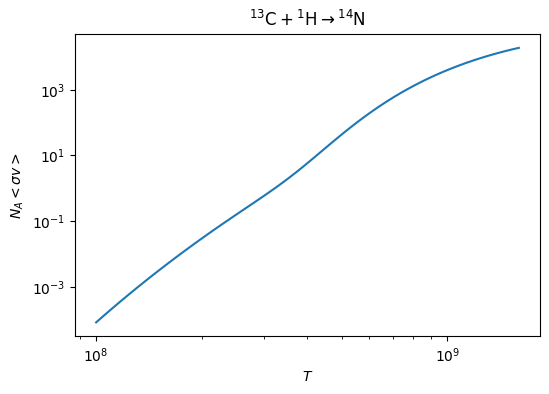

In [11]:
c13pg.plot()

### density dependence

A rate also knows its density dependence -- this is inferred from the reactants in the rate description and is used to construct the terms needed to write a reaction network.  Note: since we want reaction rates per gram, this number is 1 less than the number of nuclei

In [12]:
c13pg.dens_exp

1

## Working with a group of rates

A `RateCollection()` class allows us to work with a group of rates.  This is used to explore their relationship.  Other classes (introduced soon) are built on this and will allow us to output network code directly.

We distribute a number of popular rate files (from JINA ReacLib) in the `Library/` directory, as well as a snapshot of the entire ReacLib database.
Here we create a list with some of the individual rate files in that library:

In [5]:
files = ["c12-pg-n13-ls09", 
         "c13-pg-n14-nacr",
         "n13--c13-wc12",
         "n13-pg-o14-lg06",
         "n14-pg-o15-im05",
         "n15-pa-c12-nacr",
         "o14--n14-wc12",
         "o15--n15-wc12"]
rc = pyna.RateCollection(files)

Printing a rate collection shows all the rates

In [6]:
print(rc)

c12 + p --> n13
c13 + p --> n14
n13 --> c13
n13 + p --> o14
n14 + p --> o15
n15 + p --> he4 + c12
o14 --> n14
o15 --> n15



More detailed information is provided by `network_overview()`

In [7]:
print(rc.network_overview())

p
  consumed by:
     c12 + p --> n13
     c13 + p --> n14
     n13 + p --> o14
     n14 + p --> o15
     n15 + p --> he4 + c12
  produced by:

he4
  consumed by:
  produced by:
     n15 + p --> he4 + c12

c12
  consumed by:
     c12 + p --> n13
  produced by:
     n15 + p --> he4 + c12

c13
  consumed by:
     c13 + p --> n14
  produced by:
     n13 --> c13

n13
  consumed by:
     n13 --> c13
     n13 + p --> o14
  produced by:
     c12 + p --> n13

n14
  consumed by:
     n14 + p --> o15
  produced by:
     c13 + p --> n14
     o14 --> n14

n15
  consumed by:
     n15 + p --> he4 + c12
  produced by:
     o15 --> n15

o14
  consumed by:
     o14 --> n14
  produced by:
     n13 + p --> o14

o15
  consumed by:
     o15 --> n15
  produced by:
     n14 + p --> o15




### show a network diagram

We visualize the network using NetworkX.  By default, this does not show H or He unless we have H + H or triple-alpha reactions in the network.  This is intended to reduce clutter.

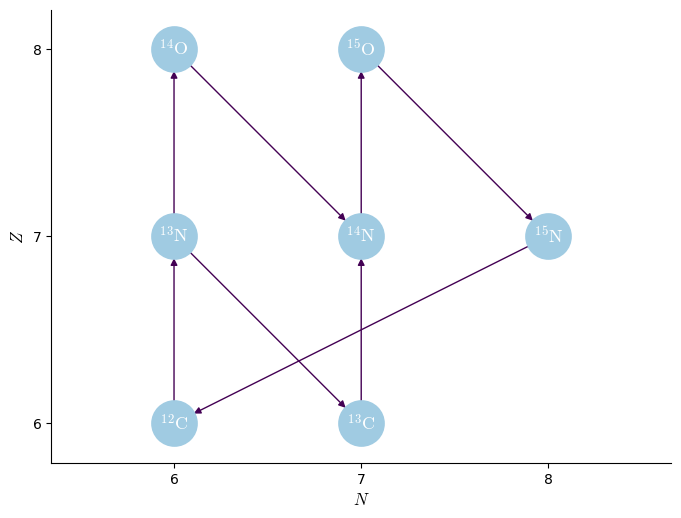

In [16]:
rc.plot()

There are many options that can be used to configure this plot, for instance, creating a rotated version (useful for very large nets).

## Explore the network's rates

To evaluate the rates, we need a composition

In [17]:
comp = pyna.Composition(rc.get_nuclei())
comp.set_solar_like()

Interactive exploration is enabled through the `Explorer` class, which takes a `RateCollection` and a `Composition`

In [13]:
re = pyna.Explorer(rc, comp)
re.explore()

interactive(children=(FloatSlider(value=4.0, description='logrho', max=6.0, min=2.0), FloatSlider(value=8.0, d…

## Plot nuclides on a grid

Nuclides in a network may also be visualized as cells on a grid of Z vs. N, colored by some quantity. This can be more interpretable for large networks. Calling `gridplot` without any arguments will just plot the grid - to see anything interesting we need to supply some conditions. Here is a plot of nuclide mass fraction on a log scale, with a 36 square inch figure:

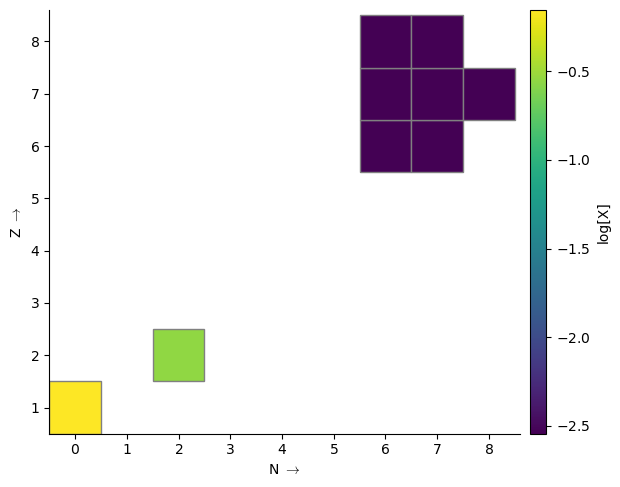

In [14]:
rc.gridplot(comp=comp, color_field="X", scale="log", area=36)

The plot is configurable through a large number of keyword arguments. Here we want to look at the rates at which nuclides are being created or destroyed, so we color by $\dot{Y}$, the rate of change of molar abundance. Density and temperature need to be supplied to evaluate the rates. A full list of valid keyword arguments can be found in the API documentation.

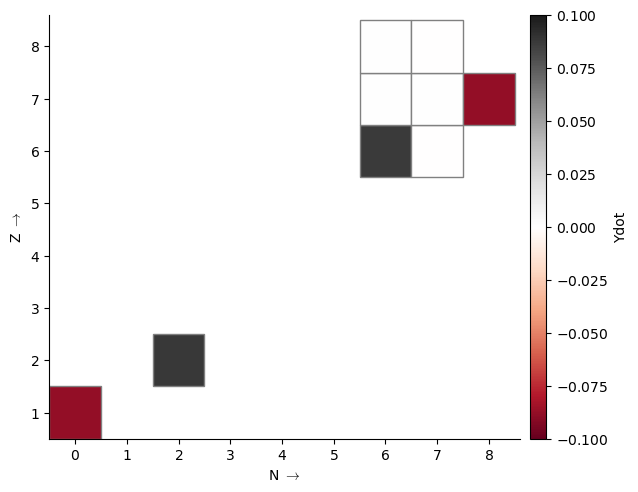

In [15]:
rc.gridplot(comp=comp, rho=1e4, T=1e8, color_field="ydot", area=36,
        cmap="RdGy", cbar_bounds=(-0.1, 0.1))

Unlike the network plot, this won't omit hydrogen and helium by default. To just look at the heavier nuclides, we can define a function to filter by proton number:

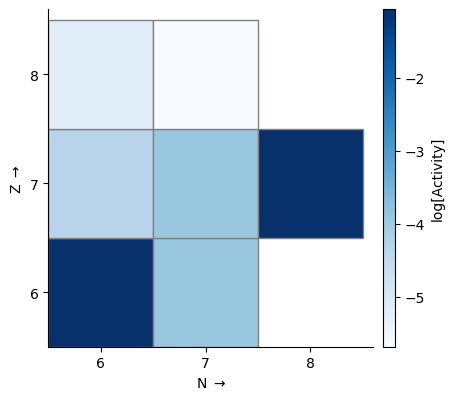

In [21]:
ff = lambda nuc: nuc.Z > 2
rc.gridplot(comp=comp, rho=1e4, T=1e8, color_field="activity", scale="log",
        filter_function=ff, area=20, cmap="Blues")